In [1]:
import pandas
import os
import sys
from pathlib import Path
import functools

In [2]:
import matplotlib
import matplotlib.pyplot

In [3]:
import sklearn.metrics

In [4]:
root_repo_dir = Path().absolute().parent
sys.path = [os.path.join(root_repo_dir,'dataexploration'),
            os.path.join(root_repo_dir,'classification'),
            os.path.join(root_repo_dir,'preprocessing'),
            os.path.join(root_repo_dir,'metrics'),
           ] + sys.path

In [5]:
# Set up some site specific parameters for the notebook
environment = 'pangeo'
env_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/csv_with_imeta',
    'pangeo': '/data/misc/xbt-data/csv_with_imeta/',
}
env_date_ranges = {
    'MO_scitools': (1996,2015),
    'pangeo': (1966,2015)
}
output_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/csv_output',
    'pangeo': '/data/misc/xbt-data/csv_output/',

}
results_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/results',
    'pangeo': '/data/misc/xbt-data/results/',

}

In [6]:
output_dir = output_dirs[environment]
results_dir = results_dirs[environment]

## Results from different classifiers

Here we compare the recall metric for the different classifiers used and different input features.

In [7]:
metrics_list = {os.path.splitext(i1)[0]: pandas.read_csv(os.path.join(results_dir, i1)) for i1 in os.listdir(results_dir) if 'xbt_metrics' in i1}

In [8]:
recall_train_instr_label = 'recall_train_instr'
recall_test_instr_label = 'recall_test_instr'
recall_unseen_instr_label = 'recall_unseen_instr'

In [9]:
d1 = {k1: v1[recall_train_instr_label] for k1,v1 in metrics_list.items() if recall_train_instr_label in v1.columns}
d1.update({'year': list(metrics_list.values())[0].year,
          'imeta_recall': list(metrics_list.values())[0].imeta_instr_recall,
          })
recall_train_df = pandas.DataFrame(d1)

In [10]:
d1 = {k1: v1[recall_test_instr_label] for k1,v1 in metrics_list.items() if recall_test_instr_label in v1.columns}
d1.update({'year': list(metrics_list.values())[0].year,
          'imeta_recall': list(metrics_list.values())[0].imeta_instr_recall,
          })
recall_test_df = pandas.DataFrame(d1)

In [11]:
d1 = {k1: v1[recall_unseen_instr_label] for k1,v1 in metrics_list.items() if recall_unseen_instr_label in v1.columns}
d1.update({'year': list(metrics_list.values())[0].year,
          'imeta_recall': list(metrics_list.values())[0].imeta_instr_recall,
          })
recall_unseen_df = pandas.DataFrame(d1)


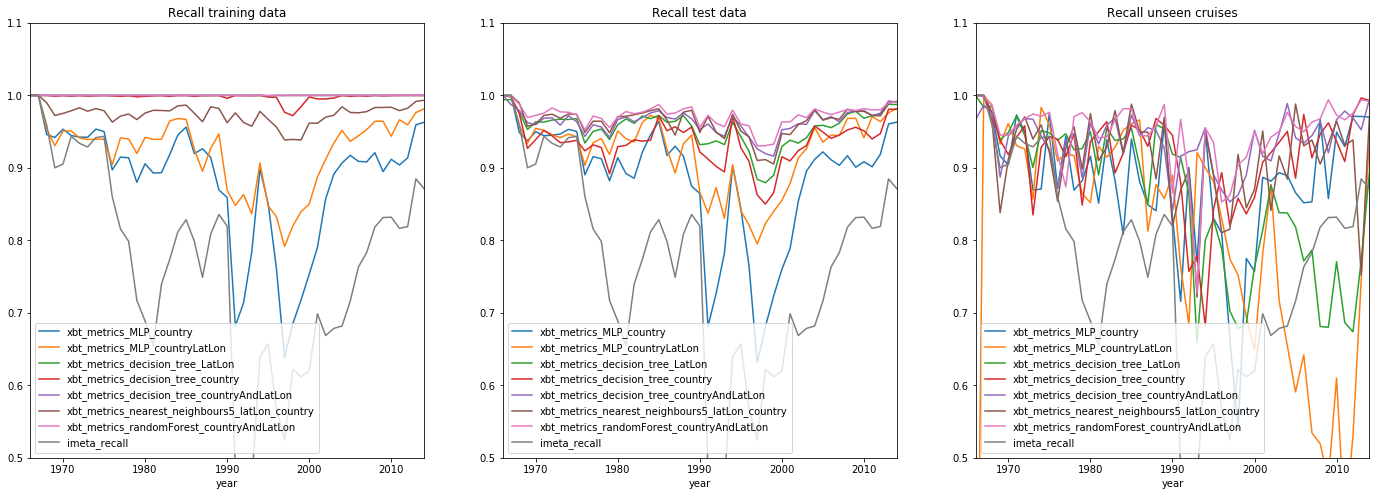

In [12]:
fig_results = matplotlib.pyplot.figure('results1', figsize=(24,8))
ax_train = fig_results.add_subplot(131, title='Recall training data')
recall_train_df.plot.line(x='year', ax=ax_train, ylim=[0.5,1.1])
ax_test = fig_results.add_subplot(132, title='Recall test data')
recall_test_df.plot.line(x='year', ax=ax_test, ylim=[0.5,1.1])
ax_unseen = fig_results.add_subplot(133, title='Recall unseen cruises')
recall_unseen_df.plot.line(x='year', ax=ax_unseen, ylim=[0.5,1.1])

## Cross-validation - comparing results for different splits

In this experiment, for each split we allocate a different subset of cruise IDs to thetest set and the rest are in the train set. For each train set, we then run hyperparameter tuning, which for each set of parameters runs cross-validation, splitting the data further into 5 different inner train/test splits. A best set of hyperparameters is then selected and used for the outer split. 

The outer split results are shown in these plots.
We see tht results vary greatly based 

In [13]:
metrics_cv_dt = pandas.read_csv('/data/misc/xbt-data/results/xbt_metrics_decision_tree_cv_country.csv')

In [14]:
d1 = {metric_name1: metrics_cv_dt[metric_name1]  for metric_name1 in metrics_cv_dt.columns if 'recall_train' in metric_name1 and '_all' in metric_name1}
d1.update({'year': list(metrics_list.values())[0].year,
          'imeta_recall': list(metrics_list.values())[0].imeta_instr_recall,
          })
recall_train_instr_cv_df = pandas.DataFrame(d1)

In [15]:
d1 = {metric_name1: metrics_cv_dt[metric_name1]  for metric_name1 in metrics_cv_dt.columns if 'recall_test' in metric_name1 and '_all' in metric_name1}
d1.update({'year': list(metrics_list.values())[0].year,
          'imeta_recall': list(metrics_list.values())[0].imeta_instr_recall,
          })
recall_test_instr_cv_df = pandas.DataFrame(d1)

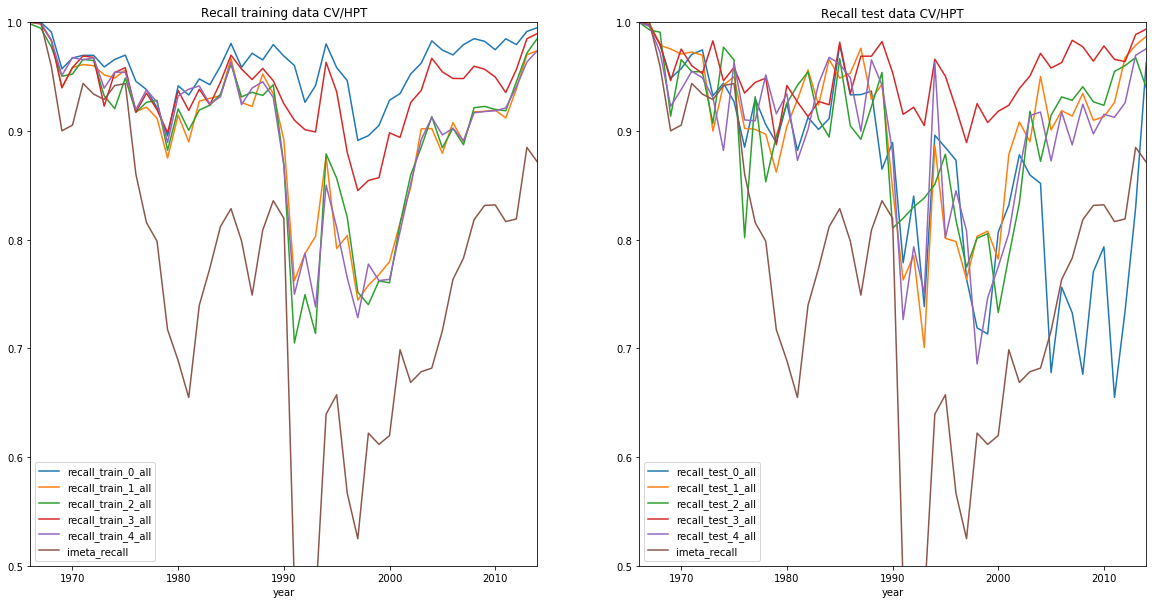

In [16]:
fig_results_cv = matplotlib.pyplot.figure('results1', figsize=(20,10))
ax_train_cv = fig_results_cv.add_subplot(121, title='Recall training data CV/HPT')
recall_train_instr_cv_df.plot.line(x='year', ax=ax_train_cv, ylim=[0.5,1.0])
ax_test_cv = fig_results_cv.add_subplot(122, title='Recall test data CV/HPT')
recall_test_instr_cv_df.plot.line(x='year', ax=ax_test_cv, ylim=[0.5,1.0])


In [17]:
d1 = {metric_name1: metrics_cv_dt[metric_name1]  for metric_name1 in metrics_cv_dt.columns if 'f1_train' in metric_name1 and '_all' in metric_name1}
d1.update({'year': list(metrics_list.values())[0].year,
          })
f1_train_instr_cv_df = pandas.DataFrame(d1)
d1 = {metric_name1: metrics_cv_dt[metric_name1]  for metric_name1 in metrics_cv_dt.columns if 'f1_test' in metric_name1 and '_all' in metric_name1}
d1.update({'year': list(metrics_list.values())[0].year,
          })
f1_test_instr_cv_df = pandas.DataFrame(d1)

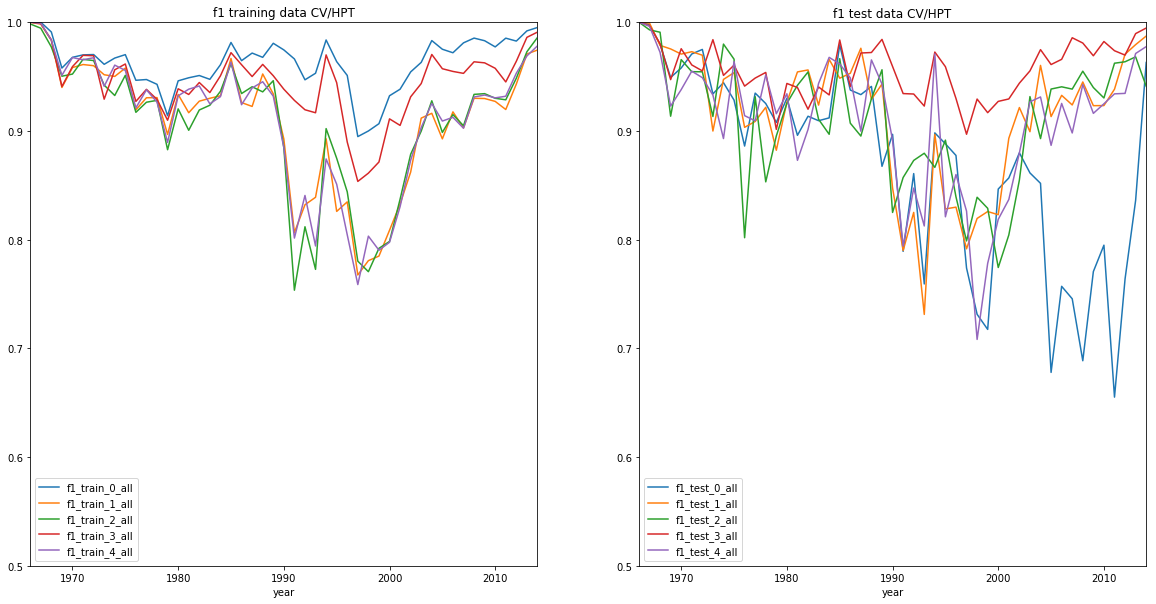

In [18]:
fig_results_cv = matplotlib.pyplot.figure('f1_cv_results', figsize=(20,10))
ax_train_f1_cv = fig_results_cv.add_subplot(121, title='f1 training data CV/HPT')
f1_train_instr_cv_df.plot.line(x='year', ax=ax_train_f1_cv, ylim=[0.5,1.0])
ax_test__f1_cv = fig_results_cv.add_subplot(122, title='f1 test data CV/HPT')
f1_test_instr_cv_df.plot.line(x='year', ax=ax_test__f1_cv, ylim=[0.5,1.0])